In [1]:
#Libraries 
import os
import time
import math
import numpy as np
import pandas as pd
import scipy
import scipy.signal as spsg
from scipy import stats
from scipy.io import loadmat
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cityblock

random.seed(42)

### Reading Data

In [2]:
# Read the data
data_path = "C:/Users/diego/Desktop/Master Neuro/M1/Mini-Project/Papers/Dynamical Structre Consciousness/phase_coherence_kmeans"

#Awake
data_awake = os.path.join(data_path, "./DK68/BOLD_timeseries_Awake.mat")
data_awake = loadmat(data_awake)
data_awake = data_awake["BOLD_timeseries_Awake"]
bold_awake_signals = np.hstack(data_awake.flatten())
print(f"Awake concatenated signals: {bold_awake_signals.shape} from {data_awake.shape[0]} patients.")

#Deep
data_deep = os.path.join(data_path, "./DK68/BOLD_timeseries_Deep.mat")
data_deep = loadmat(data_deep)
data_deep = data_deep["BOLD_timeseries_Deep"]
bold_deep_signals = np.hstack(data_deep.flatten())
print(f"Deep concatenated signals: {bold_deep_signals.shape} from {data_deep.shape[0]} patients.")

#Recovery
data_recovery = os.path.join(data_path, "./DK68/BOLD_timeseries_Recovery.mat")
data_recovery = loadmat(data_recovery)
data_recovery = data_recovery["BOLD_timeseries_Recovery"]
bold_recov_signals = np.hstack(data_recovery.flatten())
print(f"Recovery concatenated signals: {bold_recov_signals.shape} from {data_recovery.shape[0]} patients.")


Awake concatenated signals: (68, 4000) from 16 patients.
Deep concatenated signals: (68, 4000) from 16 patients.
Recovery concatenated signals: (68, 4000) from 16 patients.


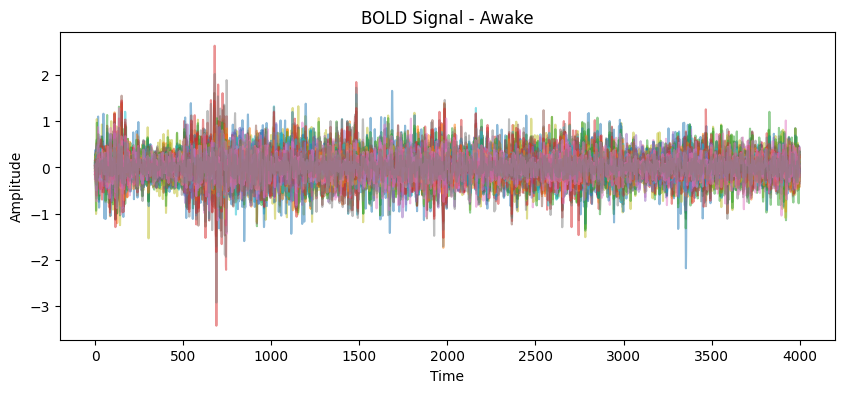

In [3]:
# Initial visualization of the Bold Signals (Time Series)
plt.figure(figsize=(10, 4))
plt.plot(bold_awake_signals.T, alpha=0.5)
plt.title("BOLD Signal - Awake")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

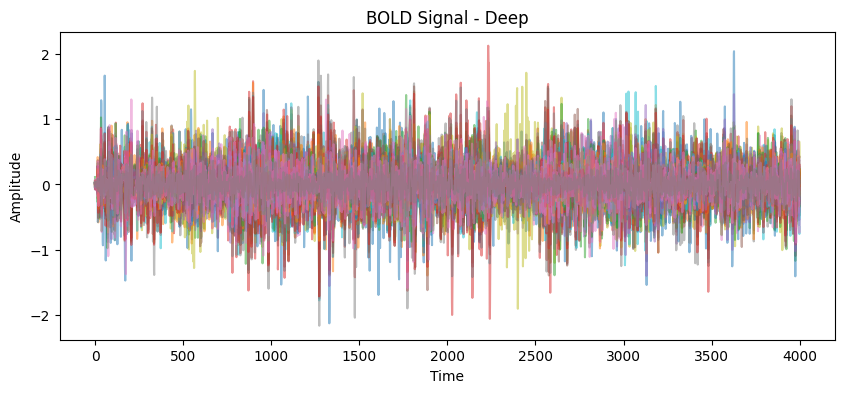

In [4]:
# Initial visualization of the Bold Signals (Time Series)
plt.figure(figsize=(10, 4))
plt.plot(bold_deep_signals.T, alpha=0.5)
plt.title("BOLD Signal - Deep")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

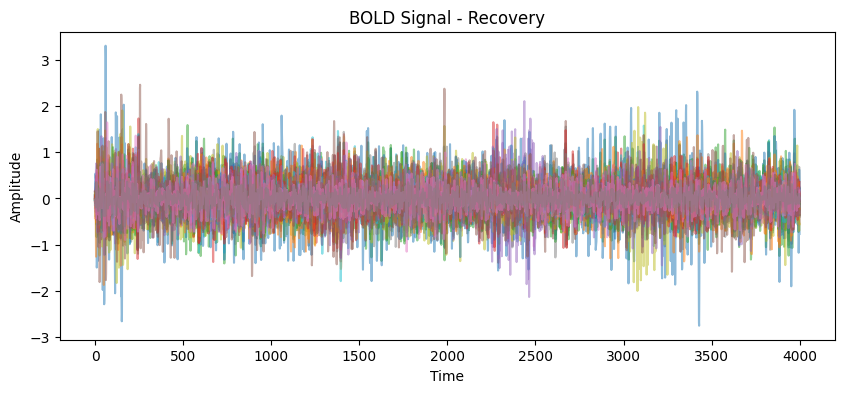

In [5]:
# Initial visualization of the Bold Signals (Time Series)
plt.figure(figsize=(10, 4))
plt.plot(bold_recov_signals.T, alpha=0.5)
plt.title("BOLD Signal - Recovery")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

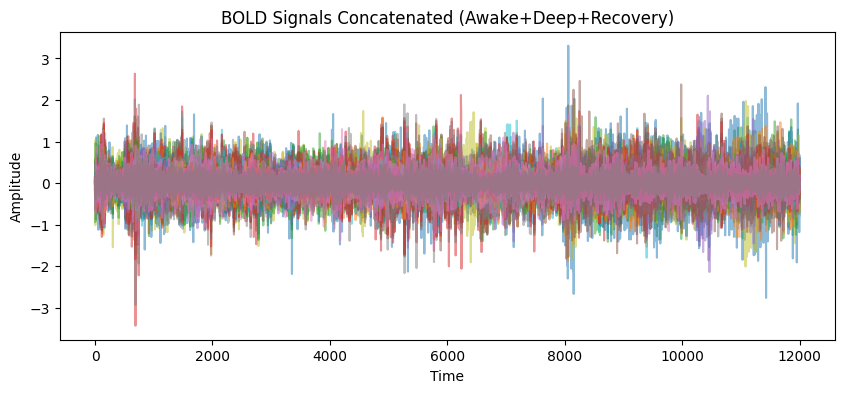

In [6]:
signals_concat = np.hstack([bold_awake_signals, bold_deep_signals, bold_recov_signals])

# Initial visualization of the Bold Signals (Time Series)
plt.figure(figsize=(10, 4))
plt.plot(signals_concat.T, alpha=0.5)
plt.title("BOLD Signals Concatenated (Awake+Deep+Recovery)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


### Extract Size and Features

In [7]:
#Number of Regions and Total Time
ROI,time_length = signals_concat.shape

# Loop over each region to extract the lenght of each signal.
Time_per_subj = np.zeros(ROI, dtype=int)
for i in range(ROI):
    Time_per_subj[i] = len(signals_concat[i])


print(f" Number of Regions (ROI): {ROI} \n Total Time: {time_length}")

 Number of Regions (ROI): 68 
 Total Time: 12000


### Import the Connectoma 

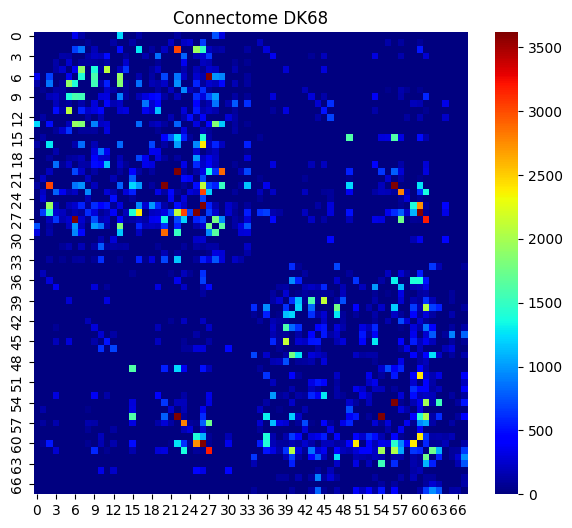

In [8]:
# Import the atlas
Connectome = loadmat("DTI_fiber_consensus_HCP.mat")['connectivity']
VConnectome = Connectome.flatten()

# Plot it
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(Connectome, cmap='jet',cbar=True, ax=ax)
ax.set_title(f"Connectome DK68")
plt.show()

In [9]:
np.info(Connectome)

class:  ndarray
shape:  (68, 68)
strides:  (8, 544)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x1a4507e8ae0
byteorder:  little
byteswap:  False
type: float64


### Preprocess Functions 

In [10]:
# Function to apply a Butterworth bandpass filter to a time series.
# It is particularly useful for removing noise and smoothing the signal in the specified frequency range.
def butterworth_filtering(ts):
    """
    Apply a Butterworth bandpass filter to the input time series `ts`.

    Parameters:
    ts : array-like
        The input time series (1D or 2D array).
        
    Returns:
    filtered_ts : array-like
        The filtered time series, same shape as input.
        
    Notes:
    - The filter settings are dependent on the experimental setup (TR = 2.4 seconds).
    - A 3rd-order Butterworth bandpass filter is applied with cutoff frequencies of 0.01 and 0.2 times the Nyquist frequency.
    - The Nyquist frequency is determined by the repetition time (TR = 2.4s).
    """
    # Parameters
    n_order = 3  # Filter order
    TR = 2.4  # Repetition time (in seconds, relevant for fMRI experiments)
    Nyquist_freq = 0.5 / TR  # Nyquist frequency (half the sampling rate)
    low_f = 0.01 / Nyquist_freq  # Low cutoff frequency (fraction of Nyquist)
    high_f = 0.2 / Nyquist_freq  # High cutoff frequency (fraction of Nyquist)
    
    # Design the Butterworth bandpass filter
    b, a = spsg.iirfilter(n_order, (low_f, high_f), btype='bandpass', ftype='butter', output='ba')
    
    # Apply the filter to the time series using zero-phase filtering
    filtered_ts = spsg.filtfilt(b, a, ts, axis=-1)
    
    return filtered_ts

In [11]:
def adif(a, b):
    """
    Calculate the angular difference between two angles `a` and `b` in radians.

    Parameters:
    a, b : float
        The input angles in radians.
        
    Returns:
    float
        The angular difference between the two angles, always in the range [0, π]. The smallest angel diffence.
    """
    if abs(a - b) > math.pi:
        return 2 * math.pi - abs(a - b)
    else:
        return abs(a - b)


### Phase difference between each pair of regions

In [12]:
timeseriedata = np.empty((ROI, time_length))
Amplitude = np.empty((ROI, time_length))
Phases = np.empty((ROI, time_length))

# For each Region we preprocess the signal to exctract instantaneous phase
for i in range(ROI):

    #Extract the signal
    ts = signals_concat[i,:]

    # Normalize the signal using Z-score
    ts_z = stats.zscore(ts)

    # Subtract the mean
    ts_z = ts_z-np.mean(ts_z,axis=0)

    # Apply the Butterworth filter 
    #ts_filtered = butterworth_filtering(ts_z)
    ts_filtered = ts_z
    
    timeseriedata[i, :] = ts_filtered

    # Perform the Hilbert transform
    hilbert_tf = spsg.hilbert(ts_z, axis=-1)
    Amplitude[i, :] = np.abs(hilbert_tf)

    # Instantaneous phase
    Phases[i, :] = np.angle(hilbert_tf)

In [13]:
# ml_out = pd.read_csv("matlab_phases_output.csv",header=None)
# ml_out=ml_out.values

In [14]:
# i = 7
# aux = ml_out[i][0:250]-Phases[i][0:250]
# plt.figure(figsize=(10, 6))
# plt.plot(aux, linewidth=2)
# plt.show()

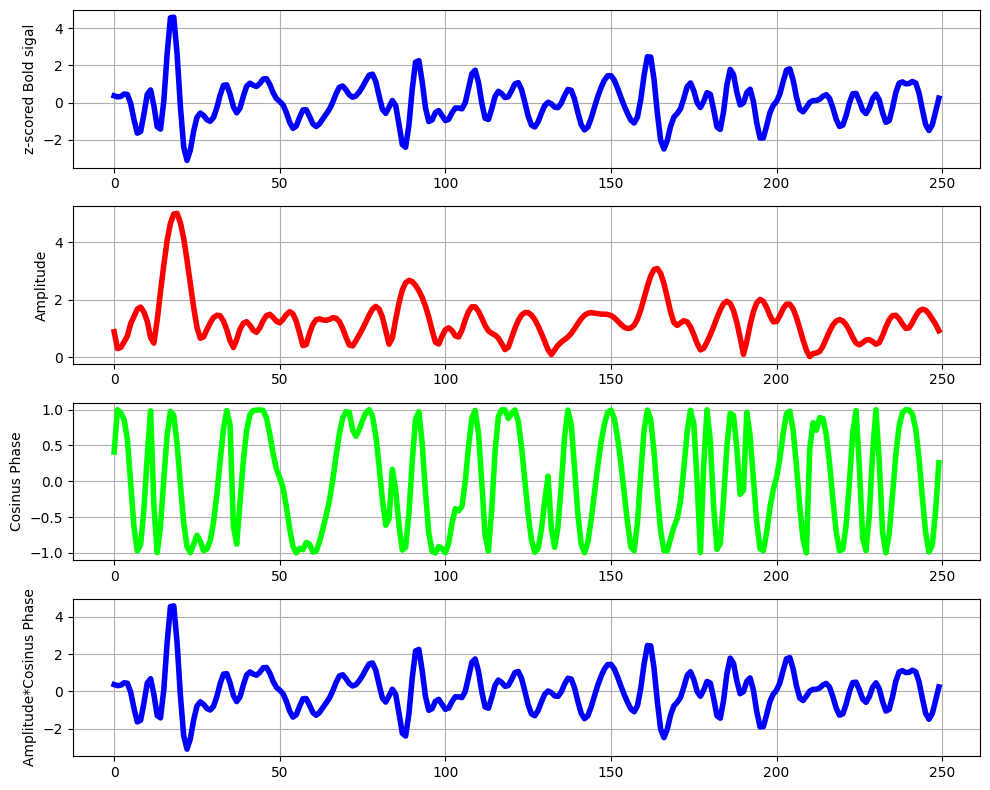

In [15]:
def createfigure(Y1, Y2, Y3, Y4):
    """
    Creates a figure with 4 vertical subplots to visualize:
    - Y1: Z-scored signal (e.g., bold)
    - Y2: Amplitude
    - Y3: Cosine of the phase
    - Y4: Amplitude * cosine of the phase
    """

    fig, axs = plt.subplots(4, 1, figsize=(10, 8))
    
    axs[0].plot(Y1, linewidth=4, color=[0, 0, 1])
    axs[0].set_ylabel('z-scored Bold sigal')
    axs[0].grid(True) 
    
    axs[1].plot(Y2, linewidth=4, color=[1, 0, 0])
    axs[1].set_ylabel('Amplitude')
    axs[1].grid(True)
    
    
    axs[2].plot(Y3, linewidth=4, color=[0, 1, 0])
    axs[2].set_ylabel('Cosinus Phase')
    axs[2].grid(True)
    
    axs[3].plot(Y4, linewidth=4, color=[0, 0, 1])
    axs[3].set_ylabel('Amplitude*Cosinus Phase')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

#We replicate a signal
Y1 = timeseriedata[0, :250]
Y2 = Amplitude[0, :250]
Y3 = np.cos(Phases[0, :250])
Y4 = Amplitude[0, :250] * np.cos(Phases[0, :250])
createfigure(Y1, Y2, Y3, Y4)

### Vectorized Computation for each time instant 

In [16]:
# # Number of pairs (only the lower part of the matrix): ROI*(ROI-1)/2
# lower_indices = np.tril_indices(ROI, k=-1)
# lower_indices_col_major = np.argsort(lower_indices[1])  # Ordenar por columnas

# # Reordenar los índices en el orden de Matlab
# lower_indices_corrected = (lower_indices[0][lower_indices_col_major], 
#                            lower_indices[1][lower_indices_col_major])


# num_pairs = len(lower_indices[0])
# pattern = np.empty((time_length, num_pairs))

# # Vectorized computation for each time instant
# for t in range(time_length):

#     phases_t = Phases[:, t]
#     diff = np.abs(phases_t[:, None] - phases_t[None, :])
#     diff = np.where(diff > np.pi, 2 * np.pi - diff, diff)
#     cos_diff = np.cos(diff)

#     # Extract only the lower part of the matrix
#     pattern[t, :] = cos_diff[lower_indices]

In [17]:
# Number of pairs (only the lower part of the matrix): ROI*(ROI-1)/2
row_idx, col_idx = np.tril_indices(ROI, k=-1)
sorted_indices = np.lexsort((row_idx, col_idx))
lower_indices_corrected = (row_idx[sorted_indices], col_idx[sorted_indices])


num_pairs = len(lower_indices_corrected[0])
pattern = np.empty((num_pairs, time_length))


# Vectorized computation for each time instant
for t in range(time_length):
    patt = np.empty((ROI, ROI))
    for i in range(ROI):
        for j in range(i):
            patt[i,j] = np.cos(adif(Phases[i,t],Phases[j,t]))
            #patt[i,j] = adif(Phases[i,t],Phases[j,t])
    pattern[:, t] = patt[lower_indices_corrected]
    

In [18]:
# ml_out=pd.read_csv("matlab_pattern_output.csv",header=None)
# ml_out=ml_out.values
# ml_out

In [19]:
# i = 0
# aux = ml_out[:,i][0:250]-pattern[:,i][0:250]
# plt.figure(figsize=(10, 6))
# plt.plot(aux, linewidth=2)
# plt.show()

In [20]:
# i = 1200
# aux = ml_out[i][0:250]-pattern[i][0:250]
# plt.figure(figsize=(10, 6))
# plt.plot(aux, linewidth=2)
# plt.show()

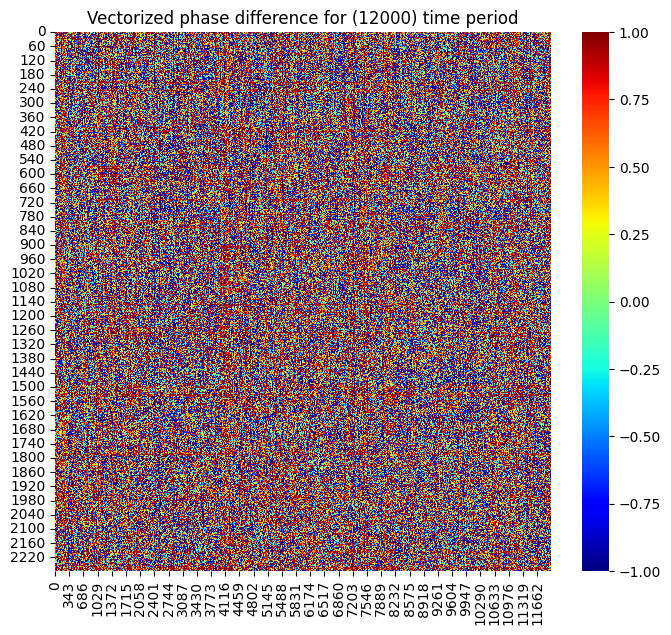

In [21]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(pattern, cmap='jet', vmin=-1, vmax=1, cbar=True, ax=ax)
ax.set_title(f"Vectorized phase difference for ({time_length}) time period")
plt.show()

In [40]:
pattern.shape

(2278, 12000)

### K-Means

In [ ]:
# Clustering options (MaxIter=200)
opts = {"max_iter": 5}

Kmeans_results = {}
mink = 3
maxk = 10

#for k in range(mink,maxk):
#for k in [5]:
# KMedoids model using the 'manhattan' metric
kmedoids = KMedoids(n_clusters=5, 
                    metric='manhattan',
                    max_iter=opts["max_iter"],
                    init='heuristic', 
                    random_state=0)
kmedoids.fit(pattern.T)

In [ ]:
# Extract cluster indices, centroids
cidx_Pha = kmedoids.labels_            
ctrs_Pha = kmedoids.cluster_centers_  
sum_D_Pha = 0.0
# For each data point, compute the Manhattan distance to the assigned centroid and sum up
for i in range(pattern.shape[0]):
    sum_D_Pha += cityblock(pattern[i], ctrs_Pha[cidx_Pha[i]])

# Store results
Kmeans_results[5] = {
    "cidx_Pha": cidx_Pha,
    "ctrs_Pha": ctrs_Pha,
    "sum_D_Pha": sum_D_Pha
}


In [ ]:
# Clustering options (MaxIter=200)
opts = {"max_iter": 5}

Kmeans_results = {}
mink = 3
maxk = 10
aux_data = pattern.T

#for k in range(mink,maxk):
for k in [5]:
    # KMedoids model using the 'manhattan' metric
    kmedoids = KMedoids(n_clusters=k, 
                        metric='manhattan',
                        max_iter=opts["max_iter"],
                        init='heuristic', 
                        random_state=0)
    kmedoids.fit(aux_data)
    
    # Extract cluster indices, centroids
    cidx_Pha = kmedoids.labels_            
    ctrs_Pha = kmedoids.cluster_centers_  
    sum_D_Pha = 0.0
    # For each data point, compute the Manhattan distance to the assigned centroid and sum up
    for i in range(aux_data.shape[0]):
        sum_D_Pha += cityblock(pattern[i], ctrs_Pha[cidx_Pha[i]])
    
    # Store results
    Kmeans_results[k] = {
        "cidx_Pha": cidx_Pha,
        "ctrs_Pha": ctrs_Pha,
        "sum_D_Pha": sum_D_Pha
    }


In [ ]:
# Verificar dimensiones
print(f"cidx_Pha shape: {Kmeans_results[5]['cidx_Pha'].shape}") 
print(f"ctrs_Pha shape: {Kmeans_results[5]['ctrs_Pha'].shape}")  
print(f"sum_D_Pha shape: {Kmeans_results[5]['sum_D_Pha'].shape}")

cidx_Pha shape: (2278,)
ctrs_Pha shape: (5, 12000)
sum_D_Pha shape: ()


### Visualization

In [ ]:
#5 K means
n_state = 5
cidx = Kmeans_results[n_state]['cidx_Pha']  # Cluster labels per time (1200)
L = cidx.shape[0]
T_shift = 9

# We flatten the Connectome
CC = Connectome
VC = CC.flatten().astype(np.float64)

# CCA Calculation
CCA = np.zeros(n_state)
for i in range(n_state):
    # Extract row i from the centroid and convert it into a symmetric matrix
    centroid_vector = Kmeans_results[n_state]['ctrs_Pha'][i, :]
    QQ = squareform(centroid_vector)
    VA = QQ.flatten()
    MC = np.corrcoef(VA, VC)
    CCA[i] = MC[0, 1]

B = np.sort(CCA)
I = np.argsort(CCA)

# Rate
rate = np.zeros(n_state)
ratea = np.zeros(n_state)
rateb = np.zeros(n_state)
ratec = np.zeros(n_state)
denom = L - 2 * T_shift

for bst in range(n_state):
    rate[bst]  = np.sum(cidx == I[bst]) / denom
    ratea[bst] = np.sum(cidx[:4000] == I[bst]) / denom
    rateb[bst] = np.sum(cidx[4000:8000] == I[bst]) / denom
    ratec[bst] = np.sum(cidx[8000:] == I[bst]) / denom

# Scrateaw, scratelpp, and scratedpp
sclen = 250
scrateaw = np.zeros((16, n_state))
scratelpp = np.zeros((16, n_state))
scratedpp = np.zeros((16, n_state))

for s in range(16):
    for j in range(n_state):
        scrateaw[s, j] = np.sum(cidx[s * sclen:(s + 1) * sclen] == I[j]) / sclen
        scratelpp[s, j] = np.sum(cidx[4000 + s * sclen:4000 + (s + 1) * sclen] == I[j]) / sclen
        scratedpp[s, j] = np.sum(cidx[8000 + s * sclen:8000 + (s + 1) * sclen] == I[j]) / sclen

# For each state, concatenate the vectors of scrateaw, scratelpp, and scratedpp vertically
grp = np.concatenate([np.zeros(16), np.ones(16), 2 * np.ones(16)])
CH = np.zeros((48, n_state))
for i in range(n_state):
    CH[:, i] = np.concatenate([scrateaw[:, i], scratelpp[:, i], scratedpp[:, i]])

ValueError: Incompatible vector size. It must be a binomial coefficient n choose 2 for some integer n >= 2.

In [ ]:
#Visualizations
plt.figure(figsize=(15, 10))

# First row: For each state, display the image (squareform of the centroid) and in the last column the Connectome
for i in range(n_state):
    plt.subplot(3, n_state + 1, i + 1)
    centroid_vector = Kmeans_results[n_state]['ctrs_Pha'][I[i], :]
    QQ = squareform(centroid_vector)
    plt.imshow(QQ, vmin=-1, vmax=1, cmap='jet', aspect='equal')
    plt.axis('off')
    plt.title(f'State {i + 1}')

# Plot Connectome
plt.subplot(3, n_state + 1, n_state + 1)
plt.imshow(CC, vmin=-1, vmax=1, cmap='jet', aspect='equal')
plt.axis('off')
plt.title('Connectome')

# Second row: Boxplots for each state
for k in range(n_state):
    plt.subplot(3, n_state + 1, n_state + 1 + k + 1)
    data_groups = [CH[0:16, k], CH[16:32, k], CH[32:48, k]]
    plt.boxplot(data_groups, patch_artist=True)
    plt.xticks([1, 2, 3], ['0', '1', '2'])
    plt.title(f'Boxplot State {k + 1}')

# Third row: Bar charts with error bars
x = np.arange(1, n_state + 1)

# Awake
plt.subplot(3, n_state + 1, 2 * n_state + 3)
ratea_norm = ratea / np.sum(ratea)
plt.bar(x, ratea_norm, color='skyblue')
error_aw = np.std(scrateaw, axis=0)
plt.errorbar(x, ratea_norm, yerr=error_aw, fmt='none', color='black')
plt.ylim(0, 0.4)
plt.ylabel('Probability Awake')
plt.title('Probability Awake')

# Deep Propofol
plt.subplot(3, n_state + 1, 2 * n_state + 4)
rateb_norm = rateb / np.sum(rateb)
plt.bar(x, rateb_norm, color='skyblue')
error_lpp = np.std(scratelpp, axis=0)
plt.errorbar(x, rateb_norm, yerr=error_lpp, fmt='none', color='black')
plt.ylim(0, 0.4)
plt.ylabel('Probability Deep Propofol')
plt.title('Probability Deep Propofol')

# Recovery
plt.subplot(3, n_state + 1, 2 * n_state + 5)
ratec_norm = ratec / np.sum(ratec)
plt.bar(x, ratec_norm, color='skyblue')
error_dpp = np.std(scratedpp, axis=0)
plt.errorbar(x, ratec_norm, yerr=error_dpp, fmt='none', color='black')
plt.ylim(0, 0.4)
plt.ylabel('Probability Recovery')
plt.title('Probability Recovery')

plt.tight_layout()
plt.show()
